In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np

Read the sdss and gaia catalogs 

In [2]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

sdss = Table.read('stripe82calibStars_v2.6.dat', format='ascii', names=colnames)

In [3]:
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr']
# gaia = Table.read('Stripe82_GaiaDR1_small.dat', format='ascii', names=colnames)
gaia = Table.read('Stripe82_GaiaDR1.dat', format='ascii', names=colnames)

Match gaia to sdss, since here sdss is much larger 

In [4]:
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['ra']*u.degree, dec= gaia['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec

# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 

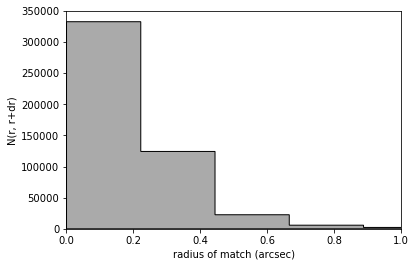

0.245502787052


In [5]:
from astroML.plotting import hist
ax = plt.axes()
hist(d2d.arcsec, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(0, 1.0)
plt.show()
print np.median(d2d.arcsec)

Select good matches

-0.0625333566177
0.188565511156


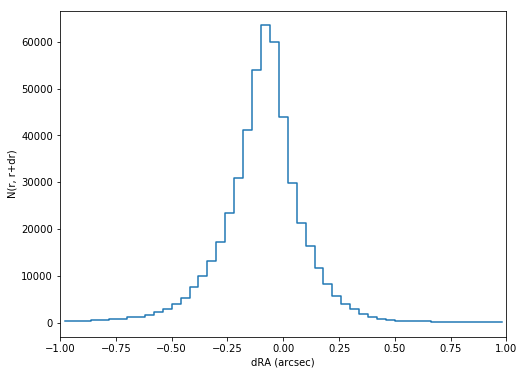

In [83]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
draOK = dra[(dra>-1.0)&(dra<1.0)]
print np.median(draOK)
print np.std(draOK)
hist, bins = np.histogram(draOK, bins=50)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dRA (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-1.0, 1.0)
plt.show()

0.0755085309542
0.135228593715


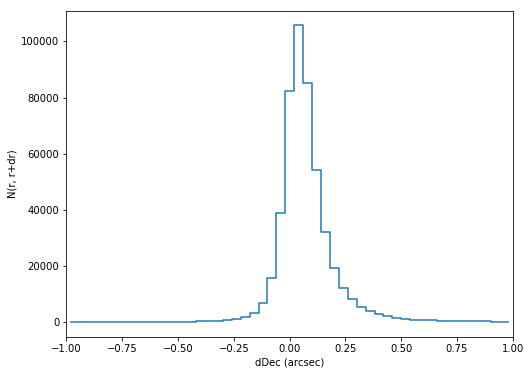

In [85]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ddecOK = ddec[(ddec>-1)&(ddec<1)]
print np.median(ddecOK)
print np.std(ddecOK)
hist, bins = np.histogram(ddecOK, bins=50)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dDec (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-1, 1)
plt.show()

In [88]:
# I would call good match to be within a certain limit 
# there is no built-in boundary - match_to_catalog_sky()
# will find the nearest match, regardless if it's an arcsecond
# or five degrees to the nearest one.

# gaia sources that have a good sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)  # 486812 for <1 arcsec
gaia_matched = gaia_sdss[flag]
print(len(gaia_sdss))
print(len(gaia_matched))

715436
466598


-0.0593348997455
0.149982916961
0.0732834054172
0.0942972681243
-0.499494576593
0.498001085157


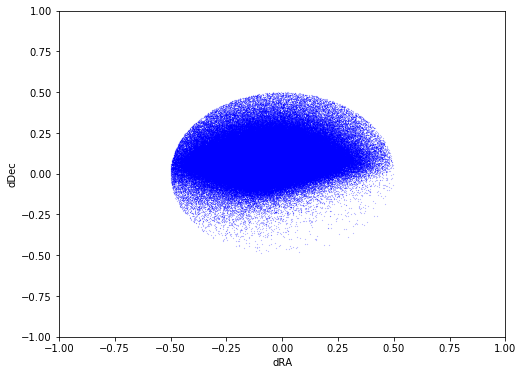

In [89]:
dra = 3600*(gaia_matched['ra_sdss'] - gaia_matched['ra_gaia']) 
ddec = 3600*(gaia_matched['dec_sdss'] - gaia_matched['dec_gaia'])  
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dra, ddec, s=0.01, c='blue')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('dRA')
ax.set_ylabel('dDec')
print np.median(dra)
print np.std(dra)
print np.median(ddec)
print np.std(ddec)
print np.min(dra)
print np.max(dra)

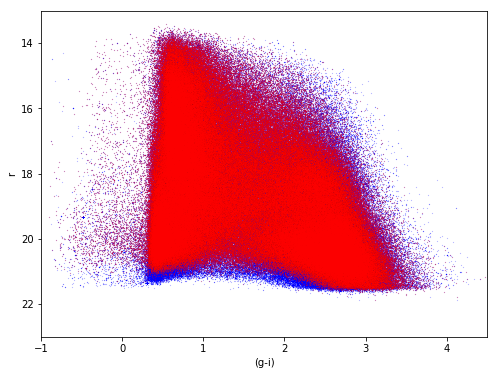

In [90]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
giAll = gaia_sdss['g_mMed'] - gaia_sdss['i_mMed']
r = gaia_matched['r_mMed']
rAll = gaia_sdss['r_mMed']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(giAll, rAll, s=0.01, c='blue')
ax.scatter(gi, r, s=0.01, c='red')
ax.set_xlim(-1,4.5)
ax.set_ylim(23,13)
ax.set_xlabel('(g-i)')
ax.set_ylabel('r')

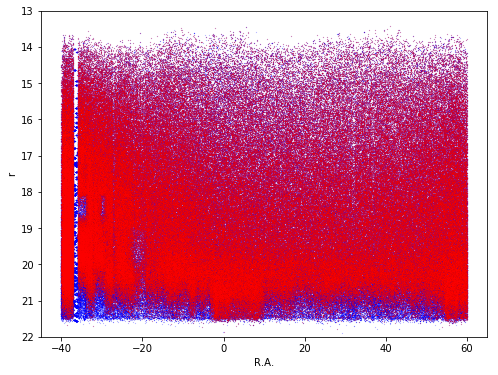

In [91]:
r = gaia_matched['r_mMed']
rAll = gaia_sdss['r_mMed']
ra = gaia_matched['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
raA = gaia_sdss['ra_gaia'] 
raAW = np.where(raA > 180, raA-360, raA)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raAW, rAll, s=0.01, c='blue')
ax.scatter(raW, r, s=0.01, c='red')
ax.set_xlim(-45,65)
ax.set_ylim(22,13)
ax.set_xlabel('R.A.')
ax.set_ylabel('r')

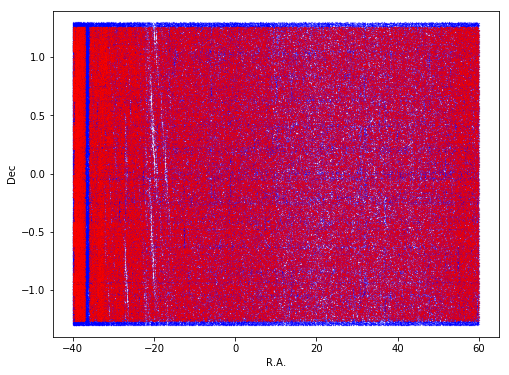

In [92]:
dec = gaia_matched['dec_gaia']
decA = gaia_sdss['dec_gaia']
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
raA = gaia_sdss['ra_gaia'] 
raAW = np.where(raA > 180, raA-360, raA)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raAW, decA, s=0.01, c='blue')
ax.scatter(raW, dec, s=0.01, c='red')
ax.set_xlim(-45,65)
ax.set_ylim(-1.4,1.4)
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec')

In [93]:
rMed = gaia_matched['r_mMed'] 
# flagOK = ((raW > -10) & (raW < 50) & (rMed>15) & (rMed<20))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19))
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

90516


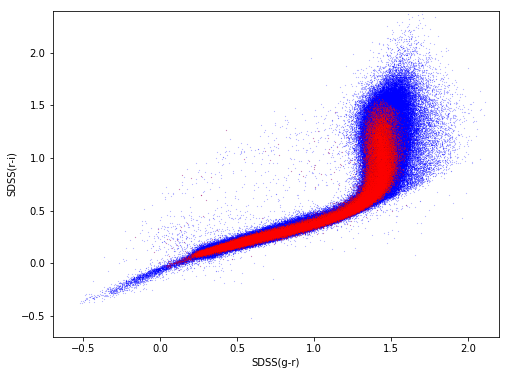

In [97]:
gr = gaia_matched['g_mMed'] - gaia_matched['r_mMed']
ri = gaia_matched['r_mMed'] - gaia_matched['i_mMed']
grOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['r_mMed']
riOK = gaia_matchedOK['r_mMed'] - gaia_matchedOK['i_mMed']
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.scatter(grOK, riOK, s=0.01, c='red')
ax.set_xlim(-0.7,2.2)
ax.set_ylim(-0.7,2.4)
ax.set_xlabel('SDSS(g-r)')
ax.set_ylabel('SDSS(r-i)')

In [98]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i], medianBin[i], sigGBin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[Npts>0]))

    return xBin, nPts, medianBin, sigGbin

In [99]:
Gr = gaia_matched['Gmag'] - gaia_matched['r_mMed']
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
# medians
#xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, -0.7, 4.0, 47, 0)
#xBinOK, nPtsOK, medianBinOK, sigGbinOK = fitMedians(giOK, GrOK, -0.2, 3.2, 34, 0)
xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, 0.0, 3.0, 30, 0)
xBinOK, nPtsOK, medianBinOK, sigGbinOK = fitMedians(giOK, GrOK, 0.0, 3.0, 30, 0)

#print xBin, nPts, medianBin, sigGbin
medOK1 = medianBin[(xBin>2)&(xBin<3)]
medOK2 = medianBinOK[(xBinOK>2)&(xBinOK<3)]
dmedOK = medOK2 - medOK1
#print dmedOK

In [100]:
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(data, theta, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(data, degree, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(data, theta, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)


In [101]:
data = np.array([xBin, medianBin, sigGbin])
x, y, sigma_y = data
theta1 = best_theta(data,1)
 

In [208]:
from scipy import stats
from scipy import optimize

# this function computes a linear combination of 4 functions
# given parameters theta
def linear_fit(coeffs, x, w, y, z):
    ffit = coeffs[0]*x + coeffs[1]*w + coeffs[2]*y + coeffs[3]*z 
    return ffit

# compute the data log-likelihood given a model
def logL(dataL, coeffs, model=linear_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, w, y, z, f, sigma_f = dataL
    f_fit = model(coeffs, x, w, y, z)
    return sum(stats.norm.logpdf(*args)
               for args in zip(f, f_fit, sigma_f))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_lintheta(dataL, degree=4, model=linear_fit):
    coeffs_0 = degree * [0]
    neg_logL = lambda coeffs: -logL(dataL, coeffs, model)
    return optimize.fmin_bfgs(neg_logL, coeffs_0, disp=False)


In [209]:
GmagOK = gaia_matchedOK['Gmag']
GG = 25.525-2.5*np.log10(gaia_matchedOK['flux'])
dG = GG - GmagOK 
print np.median(dG)
print np.std(dG)
print np.median(gaia_matchedOK['flux'])

0.00022993615946
2.23807202785e-15
2575.75924576


In [210]:
ra = gaia_matchedOK['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
gi = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
rMed = gaia_matchedOK['r_mMed']
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
Gmag = gaia_matchedOK['Gmag']
flagOK2 = (flagOK & (Gmag > 16) & (Gmag < 16.5))
gaia_matchedOK2 = gaia_matchedOK[flagOK2]
print(len(gaia_matchedOK))
print(len(gaia_matchedOK2))

51569
10710


In [211]:
fluxGaia = gaia_matchedOK2['flux']
fluxGaiaErr = gaia_matchedOK2['fluxErr']
gFlux = 10**(0.4*gaia_matchedOK2['g_mMean'])
rFlux = 10**(0.4*gaia_matchedOK2['r_mMean'])
iFlux = 10**(0.4*gaia_matchedOK2['i_mMean'])
zFlux = 10**(0.4*gaia_matchedOK2['z_mMean'])
dataL = np.array([gFlux, rFlux, iFlux, zFlux, fluxGaia, fluxGaiaErr])
x, w, y, z, f, sigma_f = dataL
coeffs1 = best_lintheta(dataL)
ffit = linear_fit(coeffs1, x, w, y, z)
dmag = -2.5*np.log10(ffit/f) 

In [215]:
print np.median(dmag)
print np.std(dmag)
print coeffs1
print np.median(f)
print np.std(f)
print np.median(ffit)
print np.std(ffit)

0.0879615018885
0.288348119715
[ 0.00012566 -0.00048733  0.00288826 -0.00095343]
5077.26085003
681.796981161
4683.35559659
632.441048813


In [214]:
fluxGaia = gaia_matchedOK['flux']
gFlux = 10**(0.4*gaia_matchedOK['g_mMean'])
rFlux = 10**(0.4*gaia_matchedOK['r_mMean'])
iFlux = 10**(0.4*gaia_matchedOK['i_mMean'])
zFlux = 10**(0.4*gaia_matchedOK['z_mMean'])
ffitOK = linear_fit(coeffs1, gFlux, rFlux, iFlux, zFlux)
dmagOK = -2.5*np.log10(ffitOK/fluxGaia) 
print np.median(dmagOK)
print np.std(dmagOK)

-1.38229830121
1.1179012128


In [102]:
data = np.array([xBin, medianBin, sigGbin])
Ndata = xBin.size
# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(data,3)
theta2 = best_theta(data,5)
theta3 = best_theta(data,7)
# generate best fit lines on a fine grid 
xfit = np.linspace(-1.1, 4.3, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

In [103]:
print "CHI2:"
print '   best linear model:', chi21
print 'best quadratic model:', chi22
print '    best cubic model:', chi23
print "CHI2 per degree of freedom:"
print '   best linear model:', chi2dof1
print 'best quadratic model:', chi2dof2
print '    best cubic model:', chi2dof3

CHI2:
   best linear model: 7744.22959516
best quadratic model: 2202.43651657
    best cubic model: 314.243382739
CHI2 per degree of freedom:
   best linear model: 276.579628399
best quadratic model: 81.5717228361
    best cubic model: 12.0862839515


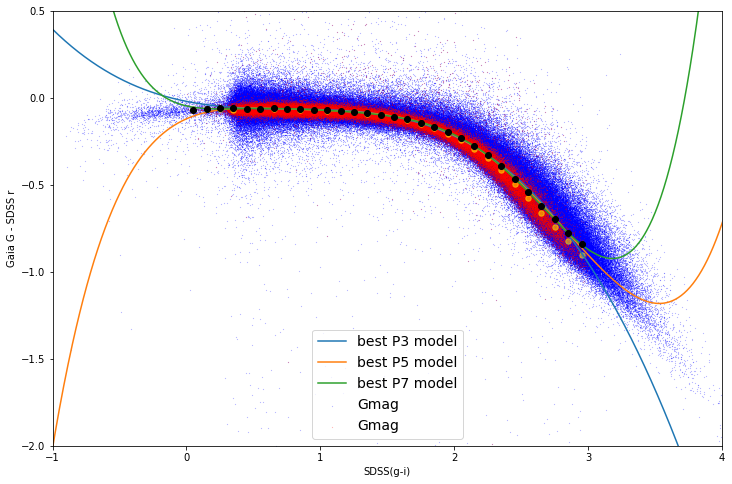

In [104]:
# Plot a (gaia - r)  vs (g-i)  for photometric transformation
%matplotlib inline
# plot
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi, Gr, s=0.01, c='blue')
ax.scatter(giOK, GrOK, s=0.01, c='red')
# medians
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.5)
ax.scatter(xBinOK, medianBinOK, s=30.0, c='yellow', alpha=0.5)
ax.set_xlim(-1,4)
ax.set_ylim(-2.0,0.5)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS r')
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best P3 model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best P5 model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best P7 model')
ax.legend(loc='best', fontsize=14)


In [105]:
print theta3

[-0.04623556 -0.17535592  0.64418678 -1.03747243  0.81762593 -0.32774888
  0.05842368 -0.00332009]


In [155]:
# GrModel = -0.06348 -0.03111*gi +0.08643*gi*gi -0.05593*gi*gi*gi
GrModel = sum(t * gi ** n for (n, t) in enumerate(theta3))
GrResid = Gr - GrModel
xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(gi, GrResid, -0.7, 4.0, 47, 0)

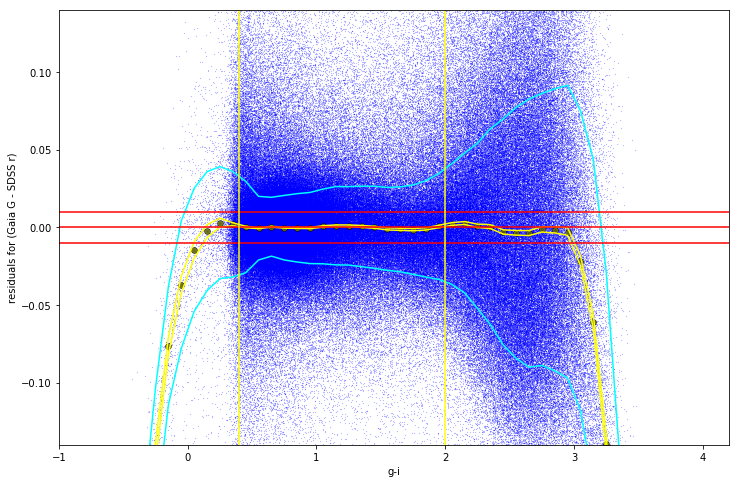

In [157]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinM, medianBinM, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinM + 2*sigGbinM
TwoSigM = medianBinM - 2*sigGbinM 
ax.plot(xBinM, TwoSigP, c='yellow')
ax.plot(xBinM, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
rmsP = medianBinM + rmsBin
rmsM = medianBinM - rmsBin
ax.plot(xBinM, rmsP, c='cyan')
ax.plot(xBinM, rmsM, c='cyan')
ax.set_xlim(-1,4.2)
ax.set_ylim(-0.14,0.14)
ax.set_xlabel('g-i')
ax.set_ylabel('residuals for (Gaia G - SDSS r)')
xL = np.linspace(-10,10)
ax.plot(xL, 0*xL+0.00, c='red')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
ax.plot(0*xL+0.4, xL, c='yellow')
ax.plot(0*xL+2.0, xL, c='yellow')

In [108]:
medOK = medianBinM[(xBinM>0.4)&(xBinM<2.0)]

In [109]:
print medOK

[  2.22064598e-04  -5.19328376e-04   4.04072523e-04  -2.13854582e-04
  -3.07759992e-04  -4.20407651e-04   5.95157868e-04   1.05895863e-03
   9.85787111e-04   5.94521129e-04   5.88473905e-05  -9.82323949e-04
  -1.26166829e-03  -1.48453490e-03  -9.57674947e-04   5.78655396e-04]


In [110]:
np.median(medOK)

-7.7503595658390267e-05

In [111]:
np.std(medOK)

0.00076837191809898888

In [112]:
np.max(medOK)

0.0010589586262552964

In [113]:
np.min(medOK)

-0.0014845348952509663

In [169]:
residOK = GrResid[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
magOK = rMed[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
gaiaG = gaia_matched['Gmag']
GOK = gaiaG[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
print np.median(residOK)
print np.std(residOK)

ERROR: ValueError: operands could not be broadcast together with shapes (466598,) (51569,)  [IPython.core.interactiveshell]


ValueError: operands could not be broadcast together with shapes (466598,) (51569,) 

In [115]:
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(magOK, residOK, 14, 20.5, 65, 0)

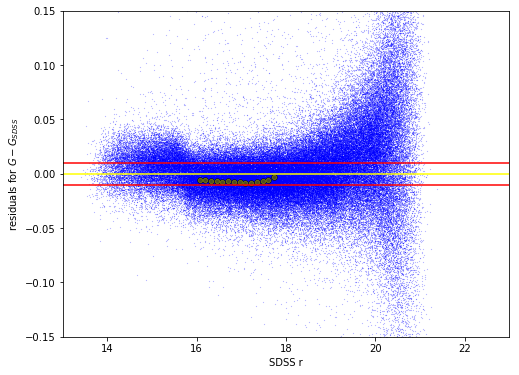

In [158]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.15,0.15)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [117]:
print medianBinMg

[  6.23208518e-03   7.55184393e-03   8.64792457e-03   9.28001409e-03
   9.04589588e-03   7.99432537e-03   7.95281795e-03   7.84528168e-03
   7.19021477e-03   6.99242359e-03   8.31207457e-03   6.92265655e-03
   7.16587267e-03   7.23091416e-03   7.15307285e-03   6.27942173e-03
   4.03719659e-03  -1.60238433e-05  -3.22739172e-03  -3.88797397e-03
  -4.02173972e-03  -3.98269201e-03  -3.91340543e-03  -3.83337200e-03
  -5.16509476e-03  -4.49359958e-03  -4.46355814e-03  -4.44358100e-03
  -4.38040539e-03  -5.38681181e-03  -4.90731806e-03  -4.54455022e-03
  -5.27098349e-03  -5.66821476e-03  -4.87942276e-03  -5.18204346e-03
  -5.18100564e-03  -4.87040991e-03  -4.21886509e-03  -4.74108978e-03
  -5.05247819e-03  -3.28256794e-03  -2.29550727e-03  -1.94871911e-03
  -1.37679916e-03  -4.02104632e-04  -6.12524107e-04   4.36146182e-04
   1.37785739e-03   1.12992982e-03   4.18424154e-03   4.75025935e-03
   7.08935865e-03   1.02353358e-02   1.13307462e-02   1.28651986e-02
   1.36973488e-02   1.72710370e-02

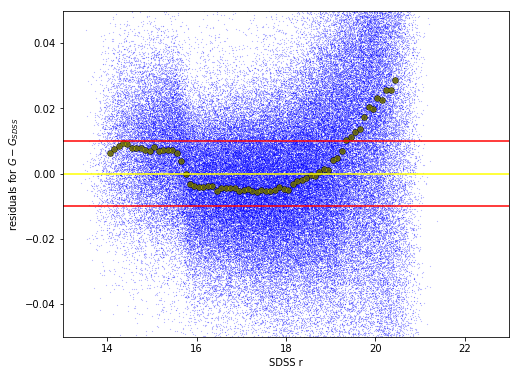

In [123]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [161]:
print magOK.size
print GOK.size

xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, residOK, 14, 20.5, 130, 0)

130398
130398


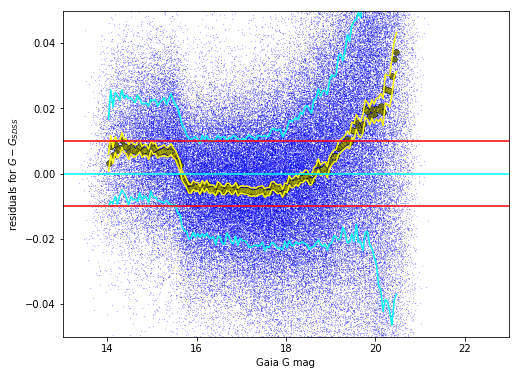

In [162]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('residuals for $G_{Gaia}-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

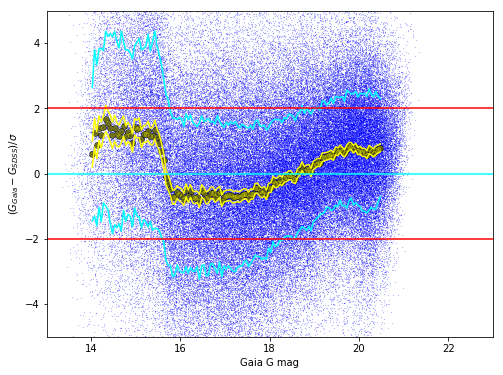

In [181]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flux = gaia_matched['flux']
fluxErr = gaia_matched['fluxErr']
fluxOK = flux[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
fluxErrOK = fluxErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
rBandErr = gaia_matched['r_mErr']
rBandErrOK = rBandErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
## Gaia's errors underestimated by a factor of ~2
sigma = np.sqrt((2*fluxErrOK/fluxOK)**2 + 1*rBandErrOK**2)
chi = residOK / sigma
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, chi, 14, 20.5, 130, 0)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, chi, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-5,5)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('($G_{Gaia}-G_{SDSS}$)/$\sigma$')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+2, c='red')
ax.plot(xL, 0*xL-2, c='red')

In [179]:
Gerr = fluxErrOK/fluxOK
print np.median(Gerr)
print np.median(rBandErrOK)

0.00405759543888
0.005


In [166]:
residOK2 = residOK[(magOK>15)&(magOK<16)]
print np.median(residOK2)
mm = medianBinMg[(xBinMg>15)&(xBinMg<16)]
xx = xBinMg[(xBinMg>15)&(xBinMg<16)]
print mm
print xx
print "transition at G ~ 15.6"

0.00354972445965
[ 0.0076122   0.00778467  0.00624245  0.00678817  0.00689529  0.00719722
  0.00657386  0.00674329  0.00753714  0.00642832  0.00575801  0.00397556
  0.00258527 -0.00068904 -0.00177113 -0.00295867 -0.00458559 -0.00463646
 -0.00345972 -0.0040951 ]
[ 15.025  15.075  15.125  15.175  15.225  15.275  15.325  15.375  15.425
  15.475  15.525  15.575  15.625  15.675  15.725  15.775  15.825  15.875
  15.925  15.975]
transition at G ~ 15.6


In [130]:
## conclusions
# 1) select:(-10 < RA < 50) & (16 < SDSSr < 19) & (0.4< g-i < 2.0)
thetaFinal = theta3
print thetaFinal

[-0.04623556 -0.17535592  0.64418678 -1.03747243  0.81762593 -0.32774888
  0.05842368 -0.00332009]


In [142]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed'] 
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<18) & (gi>0) & (gi<3.0))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

51569


In [143]:
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed'] 
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed'] 
GmagOK = gaia_matchedOK['Gmag'] 
GrModel = sum(t * giOK ** n for (n, t) in enumerate(theta3))
GrResid = GrOK - GrModel
print np.median(GrResid)
print np.std(GrResid)
print np.min(GrResid)
print np.max(GrResid)

-0.00673210467941
0.0355061821036
-1.45772912279
1.82547499834


In [144]:
#xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 18.8, 14, 0)
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 17.8, 14, 0)

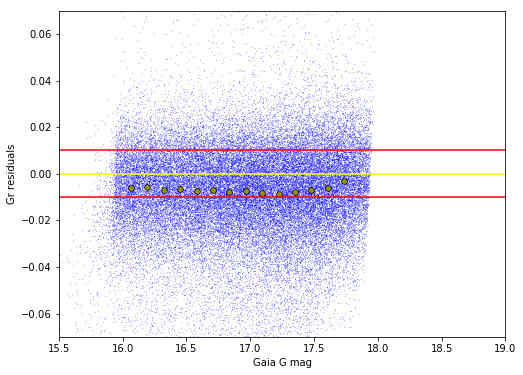

In [145]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GmagOK, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.9)
ax.scatter(xBinMg, medianBinMg, s=15.0, c='yellow', alpha=0.5)
ax.set_xlim(15.5,19)
ax.set_ylim(-0.07,0.07)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('Gr residuals')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [146]:
print np.median(medianBinMg)
print np.std(medianBinMg)

-0.00696564396959
0.00128927437282


In [147]:
GrResidN = GrResid - np.median(medianBinMg)

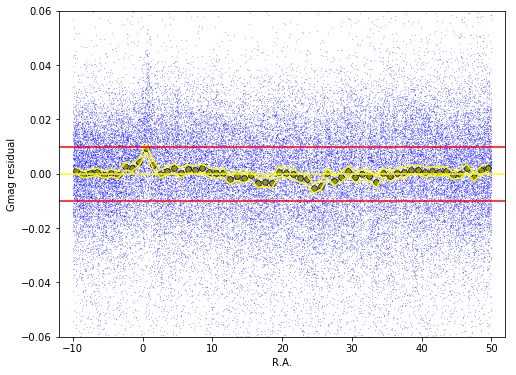

In [148]:
ra = gaia_matchedOK['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, GrResidN, s=0.01, c='blue')
ax.set_xlim(-12,52)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('R.A.')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(raW, GrResidN, -10, 50, 60, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [149]:
print np.median(medianBin)
print np.std(medianBin)
print np.min(medianBin)
print np.max(medianBin)

0.000247927225151
0.0021670699909
-0.00527176581315
0.00935919609839


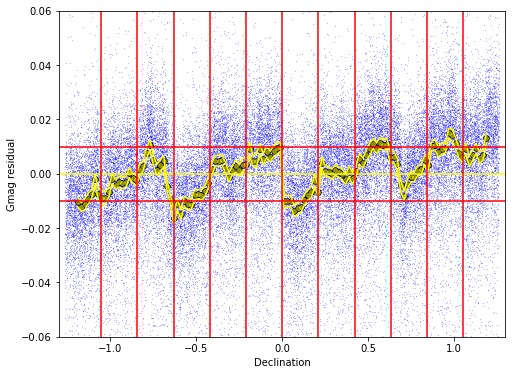

In [153]:
dec = gaia_matchedOK['dec_sdss'] 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dec, GrResidN, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(dec, GrResidN, -1.2, 1.2, 120, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
for i in range(1,12):
    decCol = -1.2655 + i*0.2109
    ax.plot(0*xL+decCol, xL, c='red')

In [151]:
print np.median(medianBin)
print np.std(medianBin)
print np.min(medianBin)
print np.max(medianBin)

0.00123686399885
0.00750053711047
-0.0164466518384
0.0148327375434
